# Task IV Diffusion Models 
 Develop a generative model to simulate realistic strong gravitational lensing images. Train a diffusion model (DDPM) to generate lensing images. You are encouraged to explore various architectures and implementations within the diffusion model framework. Please implement your approach in PyTorch or Keras and discuss your strategy.


import all the required libraries

In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import structural_similarity as ssim_metric
from tqdm import tqdm

from denoising_diffusion_pytorch import Unet, GaussianDiffusion


setting environment

In [ ]:
#  Configuration of Model
data_path = "/kaggle/input/datasetiv/Samples"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
image_size = 128

import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T


dataset have greyscale 10000 images in Samples folder. 

In [ ]:

class LensDataset(Dataset):
    def __init__(self, data_dir, image_size=64):
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),  # resizing if needed
            T.Normalize(0.0, 1.0)  # normalize assuming values in [0,1]
        ])
        self.image_size = image_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = np.load(self.files[idx])

        # Handle unexpected shapes
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)  # (1, H, W)
        elif img.ndim == 3 and img.shape[0] != 1:
            img = img[None, ...]  # Add batch-like dimension

        img = torch.tensor(img, dtype=torch.float32)

        # Resize manually if needed (torchvision Resize only works with PIL)
        if img.shape[1:] != (self.image_size, self.image_size):
            img = torch.nn.functional.interpolate(img.unsqueeze(0), size=(self.image_size, self.image_size), mode='bilinear', align_corners=False).squeeze(0)

        img = img.clamp(0., 1.)  # ensure valid range
        return img


The implementation uses two main classes from denoising_diffusion_pytorch:
1. UNet Architecture:  The U-Net learns to progressively denoise images during diffusion.
   <br>
Hierarchical downsampling/upsampling with skip connections.

Adapted for grayscale inputs (channels=1).

Channel dimensions expand (128 → 256 → 512) and contract symmetrically.

2. Gaussian Diffusion Process


Forward Process: Gradually adds Gaussian noise over T=1000 steps.

Reverse Process: The U-Net learns to denoise by predicting either:

Noise (objective='pred_noise'), or

Original image (pred_x0).

Efficient Sampling: Uses only 250 steps during generation (denoising).

In [ ]:
#  Model 
from denoising_diffusion_pytorch import Unet

model = Unet(
    dim=128,
    dim_mults=(1, 2, 4),
    channels=1  # for grayscale images
)

#  Diffusion Process 
from denoising_diffusion_pytorch import GaussianDiffusion

diffusion = GaussianDiffusion(
    model,
    image_size=64,
    timesteps=1000,   # number of diffusion steps
    sampling_timesteps=250,  # optional, using less steps for sampling
    objective='pred_noise'   # or 'pred_x0'
).cuda()


Preprocessing:

Expands dimensions for 2D inputs → (1, H, W).

Resizes to image_size (64×64) using bilinear interpolation.

Normalizes to [0, 1] range and clamps values.

DataLoader

Batches images (batch_size=16) with shuffling.

Uses multi-threaded loading (num_workers=2).

In [ ]:

#  DataLoader 
dataset = LensDataset(data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#  Optimizer 
optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-4)


Optimization
Optimizer: AdamW (lr=1e-4), ideal for diffusion models.

Loss: Mean Squared Error (MSE) between predicted and actual noise.

Training Steps
Forward Diffusion:

For each batch, noise is added over random timesteps t ∈ [1, T].

Noise Prediction:

The U-Net learns to predict the noise added at t.

Backpropagation:

Gradient updates via loss.backward().

Monitoring
Per-epoch average loss is logged.

Progress bars (tqdm) track batch-level metrics.

In [13]:



#  Training Loop 
epochs = 50
for epoch in range(epochs):
    diffusion.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    total_loss = 0

    for batch in pbar:
        batch = batch.to(device)
        loss = diffusion(batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len(dataloader):.4f}")

    #  Evaluation 
    diffusion.eval()
    with torch.no_grad():
        real_imgs, fake_imgs = [], []
        for batch in dataloader:
            batch = batch.to(device)
            sampled = diffusion.sample(batch_size=batch.shape[0])
            real_imgs.extend(batch.cpu())
            fake_imgs.extend(sampled.cpu())
            break  # evaluate on one batch only

        mse_total, ssim_total = 0, 0
        for real, fake in zip(real_imgs, fake_imgs):
            real_np = real.squeeze().numpy()
            fake_np = fake.squeeze().numpy()

            mse = np.mean((real_np - fake_np) ** 2)
            ssim = ssim_metric(real_np, fake_np, data_range=1.0)

            mse_total += mse
            ssim_total += ssim

        mse_avg = mse_total / len(real_imgs)
        ssim_avg = ssim_total / len(real_imgs)
        print(f"SSIM: {ssim_avg:.4f}, MSE: {mse_avg:.6f}")

        # Save sample grid
        os.makedirs("generated", exist_ok=True)
        for i, img in enumerate(fake_imgs[:8]):
            img = img.squeeze().numpy()
            Image.fromarray(((img + 1) * 127.5).astype(np.uint8)).save(f"generated/sample_{epoch+1}_{i}.png")

Epoch 1/50: 100%|██████████| 625/625 [05:38<00:00,  1.84it/s, loss=0.0109] 

Epoch 1, Avg Loss: 0.0439


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.0105, MSE: 0.173657


Epoch 2/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00468]

Epoch 2, Avg Loss: 0.0107


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5222, MSE: 0.014201


Epoch 3/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.0237] 

Epoch 3, Avg Loss: 0.0078


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5672, MSE: 0.015589


Epoch 4/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00554]

Epoch 4, Avg Loss: 0.0070


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.4445, MSE: 0.014520


Epoch 5/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00473]

Epoch 5, Avg Loss: 0.0059


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.3693, MSE: 0.021560


Epoch 6/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00771]

Epoch 6, Avg Loss: 0.0056


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6225, MSE: 0.010893


Epoch 7/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.0041] 

Epoch 7, Avg Loss: 0.0051


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5676, MSE: 0.012717


Epoch 8/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00819]

Epoch 8, Avg Loss: 0.0060


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6256, MSE: 0.011781


Epoch 9/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.0036] 

Epoch 9, Avg Loss: 0.0052


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5240, MSE: 0.014218


Epoch 10/50: 100%|██████████| 625/625 [05:38<00:00,  1.84it/s, loss=0.0039] 

Epoch 10, Avg Loss: 0.0047


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6076, MSE: 0.012577


Epoch 11/50: 100%|██████████| 625/625 [05:39<00:00,  1.84it/s, loss=0.00585]

Epoch 11, Avg Loss: 0.0048


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6197, MSE: 0.012365


Epoch 12/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00324]

Epoch 12, Avg Loss: 0.0047


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5746, MSE: 0.013714


Epoch 13/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.0036] 

Epoch 13, Avg Loss: 0.0050


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5031, MSE: 0.020201


Epoch 14/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00243]

Epoch 14, Avg Loss: 0.0045


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5623, MSE: 0.014290


Epoch 15/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00246]

Epoch 15, Avg Loss: 0.0047


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5760, MSE: 0.012344


Epoch 16/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00383]

Epoch 16, Avg Loss: 0.0045


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6356, MSE: 0.010095


Epoch 17/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00298]

Epoch 17, Avg Loss: 0.0044


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6735, MSE: 0.011506


Epoch 18/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00279]

Epoch 18, Avg Loss: 0.0046


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6123, MSE: 0.010462


Epoch 19/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00511]

Epoch 19, Avg Loss: 0.0044


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6652, MSE: 0.011815


Epoch 20/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.0105] 

Epoch 20, Avg Loss: 0.0045


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5702, MSE: 0.011209


Epoch 21/50: 100%|██████████| 625/625 [05:39<00:00,  1.84it/s, loss=0.00317]

Epoch 21, Avg Loss: 0.0042


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6799, MSE: 0.014138


Epoch 22/50: 100%|██████████| 625/625 [05:39<00:00,  1.84it/s, loss=0.00258]

Epoch 22, Avg Loss: 0.0044


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5914, MSE: 0.012693


Epoch 23/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00403]

Epoch 23, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6057, MSE: 0.013882


Epoch 24/50: 100%|██████████| 625/625 [05:39<00:00,  1.84it/s, loss=0.00449]

Epoch 24, Avg Loss: 0.0042


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6865, MSE: 0.012245


Epoch 25/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00867]

Epoch 25, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5819, MSE: 0.010613


Epoch 26/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.0179] 

Epoch 26, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6637, MSE: 0.011833


Epoch 27/50: 100%|██████████| 625/625 [05:38<00:00,  1.84it/s, loss=0.00903]

Epoch 27, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.3535, MSE: 0.018672


Epoch 28/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.0146] 

Epoch 28, Avg Loss: 0.0042


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6596, MSE: 0.011746


Epoch 29/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00376]

Epoch 29, Avg Loss: 0.0044


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.7189, MSE: 0.010533


Epoch 30/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00241]

Epoch 30, Avg Loss: 0.0042


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6800, MSE: 0.013862


Epoch 31/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00489]

Epoch 31, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.7241, MSE: 0.007737


Epoch 32/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.003]  

Epoch 32, Avg Loss: 0.0042


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.7118, MSE: 0.011060


Epoch 33/50: 100%|██████████| 625/625 [05:38<00:00,  1.85it/s, loss=0.00282]

Epoch 33, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6625, MSE: 0.011034


Epoch 34/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.0025] 

Epoch 34, Avg Loss: 0.0039


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6465, MSE: 0.015901


Epoch 35/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.004]  

Epoch 35, Avg Loss: 0.0038


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6619, MSE: 0.012612


Epoch 36/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00297]

Epoch 36, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6905, MSE: 0.013702


Epoch 37/50: 100%|██████████| 625/625 [05:38<00:00,  1.84it/s, loss=0.00541]

Epoch 37, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6044, MSE: 0.013647


Epoch 38/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00258]

Epoch 38, Avg Loss: 0.0041


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6927, MSE: 0.011401


Epoch 39/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00351]

Epoch 39, Avg Loss: 0.0038


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6586, MSE: 0.013956


Epoch 40/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00505]

Epoch 40, Avg Loss: 0.0039


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6663, MSE: 0.013003


Epoch 41/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00579]

Epoch 41, Avg Loss: 0.0039


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5295, MSE: 0.013378


Epoch 42/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00402]

Epoch 42, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5787, MSE: 0.017218


Epoch 43/50: 100%|██████████| 625/625 [05:35<00:00,  1.86it/s, loss=0.00641]

Epoch 43, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.5891, MSE: 0.012990


Epoch 44/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00866]

Epoch 44, Avg Loss: 0.0037


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6720, MSE: 0.012468


Epoch 45/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.0074] 

Epoch 45, Avg Loss: 0.0038


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.7231, MSE: 0.011850


Epoch 46/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00291]

Epoch 46, Avg Loss: 0.0037


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6908, MSE: 0.011901


Epoch 47/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00596]

Epoch 47, Avg Loss: 0.0039


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6687, MSE: 0.012681


Epoch 48/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00193]

Epoch 48, Avg Loss: 0.0040


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6972, MSE: 0.013029


Epoch 49/50: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=0.00285]

Epoch 49, Avg Loss: 0.0039


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6853, MSE: 0.012265


Epoch 50/50: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=0.00387]

Epoch 50, Avg Loss: 0.0038


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

SSIM: 0.6984, MSE: 0.012108


SSIM (Structural Similarity):

Measures perceptual quality between real/fake images.

MSE (Mean Squared Error):

Pixel-wise difference (lower = better reconstruction).

Sampling Process: <br>

Denoising: Starts from pure noise (x_T) and iteratively applies the U-Net to predict x_{t-1}.

Acceleration: Uses only 250 steps (25% of T) for faster generation.

Generated Samples
Saved as PNGs in ./generated/.

Scaled from [0, 1] to [0, 255] for visualization.

In [14]:
import matplotlib.pyplot as plt

def show_reconstruction(diffusion, dataloader, device, num_images=5):
    diffusion.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            # Get reconstruction (single denoising step or full sampling based on your model)
            reconstructed = diffusion.sample(batch.shape[0])
            break  # only take first batch

    # Plot original and reconstructed
    for i in range(num_images):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(batch[i].cpu().squeeze(), cmap='gray')
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axs[1].set_title("Reconstructed")
        axs[1].axis('off')

        plt.show()


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

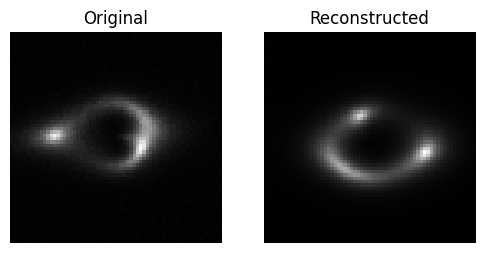

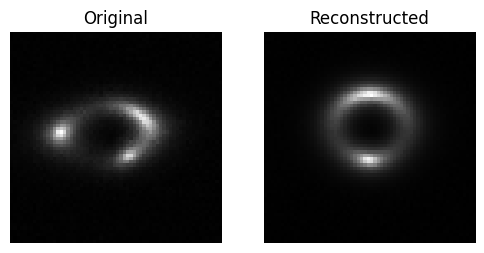

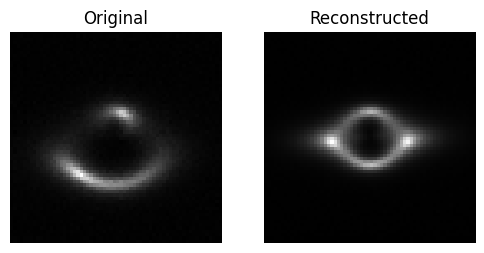

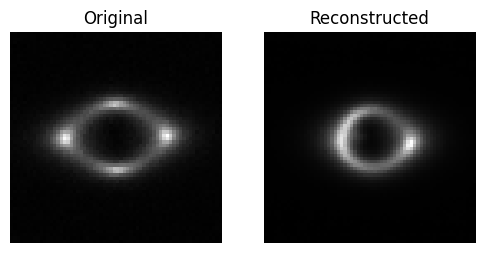

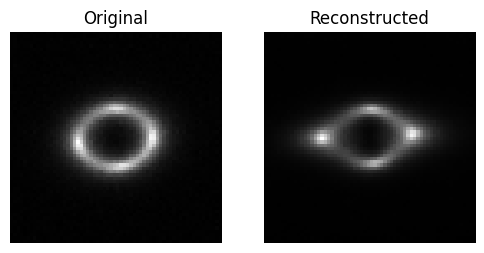

In [15]:
show_reconstruction(diffusion, dataloader, device)


Grayscale Support:

U-Net configured for single-channel input/output.

Image Size:

Model processes 64×64 images (resized from original 128×128 for efficiency).

Diffusion Parameters:

timesteps=1000: Balances training stability and computational cost.

sampling_timesteps=250: Trade-off between quality and speed.

Normalization:

Inputs clamped to [0, 1] to avoid artifacts.

This DDPM implementation:

Trains a U-Net to denoise grayscale images through 1000 diffusion steps.

Generates samples via an accelerated reverse process (250 steps).

Evaluates using SSIM/MSE on a held-out batch each epoch.

Saves samples periodically for qualitative inspection.